# Projet 7 : Réalisez des indexations automatiques d’images
# <u>C. Classification avec les Réseaux de Neurones Convolutionnels</u> <br/>

# Le contexte

Pour aider une association de protection des animaux, nous mettons en place une solution de détéction automatique de la race d'un chien à partir d'une photo de celui-ci. Nous essayerons une approche classique dans un premier temps, puis une approche basée sur les réseaux de neurones.

Dans ce notebook nous allons essayer les approches basées sur les réseaux de neurones convolutionels. Nous avons utilisé Google Colaboratory pour exécuter ce Notebook. Colab offre une accélaration matérielle qui nous a fait gagner énormement de temps de calcul. 

# Google Colab setup

- On commence par récupérer les données dans notre VM Colaboratory.

In [0]:
#! kill -9 -1
COLAB=True

In [2]:
if (COLAB) :
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    import zipfile, os
    import shutil
    from google.colab import files

    
    # HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=1Soh3zXLXt2lT7b_3FcWWyeOCC7SnOxK0 )
    #train_zip_id = '1tq2BdlFZNwCXWFDwz_Ru-ikD9HGu68BA'
    train_zip_id = '1t9wGp_jVOKR2sOWz5TB9rTuvaB_A6p96'
    test_zip_id = '1gPxoxcHpdf8djLB5SAoRfT3ecP1UBmx_'
    
    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Create Data directory
    if (os.path.exists('data')) :
        shutil.rmtree('data')
        os.makedirs('data')
        
    # DOWNLOAD ZIP
    print ("Downloading zip file train_cnn")
    myzip = drive.CreateFile({'id': train_zip_id})
    myzip.GetContentFile('train_cnn.zip')
    myzip2 = drive.CreateFile({'id': test_zip_id})
    myzip2.GetContentFile('test_cnn.zip')
    
    # UNZIP ZIP
    print ("Uncompressing zip file")
    zip_ref = zipfile.ZipFile('train_cnn.zip', 'r')
    zip_ref.extractall('data/.')
    zip_ref.close()
    
    zip_ref2 = zipfile.ZipFile('test_cnn.zip', 'r')
    zip_ref2.extractall('data/.')
    zip_ref2.close()

Uncompressing zip file


# Importation des librairies

In [10]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import os
import math 
from time import time
import pickle


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications import resnet50
from keras.applications.resnet50 import ResNet50
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense 
from keras.callbacks import ModelCheckpoint  
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier




Using TensorFlow backend.


# 1. Préparation des données

## Variables

In [0]:
# dimensions of our images.  
img_width, img_height = 224, 224
num_classes = 4
   
train_data_dir = './data/train_cnn'  
test_data_dir = './data/test_cnn' 

batch_size = 32

seed=7

breedNamesIndex = {}

# 2. Extraction des features bottleneck

Nous avons utilisé la puissance des réseaux de neurones à convolution particulièrement efficace dans le tri d'image. Nous avons utilisé Keras qui est une librairie qui offre une interface haut niveau de deep learning et qui fonctionne au dessus de différents frameworks comme TensorFlow ou Theano.<br/>

Nous nous sommes basés sur les techniques de transfert learning dont le principe est d'utiliser les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin de résoudre le notre. Nous utiliserons pour celà les réseaux VGG16, ResNet50 et Inception_V3 qui ont été entrainés pour les données ImageNet et qui sont complètement intégrés dans Keras.

## 2.1 Méthodes génériques

In [0]:
'''
Retourne une instance du modèle et la méthode de pré-traitement du réseau model_name
'''
def get_model_parameters(model_name) :
    model = None, 
    preprocess_input=None
    if (model_name == 'vgg16') :
        model = VGG16(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))
        preprocess_input = vgg16.preprocess_input
    elif (model_name == 'resNet50') :
        model = ResNet50(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))
        preprocess_input = resnet50.preprocess_input
    elif (model_name == 'inceptionV3') :
        model = InceptionV3(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))
        preprocess_input = inception_v3.preprocess_input
    else :
        print("Connais pas celui-la désolé !")
    return model, preprocess_input

In [0]:
'''
Dictionnaire faisant le mapping entre valeur numérique et nom de la classe de race de chien.
'''
def saveBreedsIndex() :
    global breedNamesIndex
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical', shuffle=False)
    labels_dictionary = generator.class_indices
    breedNamesIndex = {v: k for k, v in labels_dictionary.items()}
    with open('breedNamesIndex.pkl', 'wb') as f:
        pickle.dump(breedNamesIndex, f, pickle.HIGHEST_PROTOCOL)
    files.download('breedNamesIndex.pkl')

In [0]:
'''
Extraction des features bottlenecks. Ce sont les features obtenus par les couches se situant 
avec les couches Fully Connected du réseau de neurone
'''

def extract_features(model, generator, save_filename) :
    nb_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)
    predict_size = int(math.ceil(nb_samples / batch_size))
    
    # Si un fichier de features est trouvé, on ne refait pas tout le calcul.
    if os.path.exists(save_filename):
        print('bottleneck features detected ', save_filename)
        features = np.load(save_filename)
    else :
        print('calculating ...')
        features = model.predict_generator(generator, predict_size, verbose=1)
        np.save(save_filename, features)

    # get the class lebels for the training data, in the original order 
    labels = generator.classes 
    # convert the training labels to categorical vectors
    #labels = to_categorical(labels, num_classes=num_classes)
    return features, labels

In [0]:
'''
Extraction des features bottlenecks. Ce sont les features obtenus par les couches se situant 
avec les couches Fully Connected du réseau de neurone
'''


def get_bottleneck_features(model_name) :
    model, preprocess_input = get_model_parameters(model_name)
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)#, rescale=1. / 255)
    
    # Train data
    save_train = model_name + '_' + 'features_train.npy'
    generator_train = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), 
                                            batch_size=batch_size, class_mode='categorical', shuffle=False)
    bottleneck_features_train, train_labels = extract_features(model, generator_train, save_train)
    
    # Test data
    save_test = model_name + '_' + 'features_test.npy'
    generator_test = datagen.flow_from_directory(test_data_dir, target_size=(img_width, img_height), 
                                            batch_size=batch_size, class_mode='categorical', shuffle=False)
    bottleneck_features_test, test_labels = extract_features(model, generator_test, save_test)
    labels_dictionary = generator_train.class_indices  
    
    return bottleneck_features_train, train_labels, bottleneck_features_test, test_labels, labels_dictionary

In [16]:
saveBreedsIndex()

Found 2000 images belonging to 4 classes.


## 2.2 VGG16

- On construit les bottleneck features de VGG16

In [17]:
x_train_vgg16, y_train_vgg16, x_test_vgg16, y_test_vgg16, vggLabelsDict = get_bottleneck_features("vgg16")

58892288/58889256 [==============================] - 4s 0us/step
Found 2000 images belonging to 4 classes.
calculating ...
63/63 [==============================] - 22s 352ms/step
Found 354 images belonging to 4 classes.
calculating ...
12/12 [==============================] - 4s 306ms/step


## 2.3 ResNet50

- On construit les bottleneck features de ResNet50

In [18]:
x_train_resNet50, y_train_resNet50, x_test_resNet50, y_test_resNet50, resnetLabelsDict = get_bottleneck_features("resNet50")

94658560/94653016 [==============================] - 2s 0us/step
Found 2000 images belonging to 4 classes.
calculating ...
63/63 [==============================] - 24s 384ms/step
Found 354 images belonging to 4 classes.
calculating ...
12/12 [==============================] - 4s 346ms/step


## 2.4 Inception V3

- On construit les bottleneck features de InceptionV3

In [19]:
x_train_inceptionV3, y_train_inceptionV3, x_test_inceptionV3, y_test_inceptionV3, inceptionLabelsDict = get_bottleneck_features("inceptionV3")

87916544/87910968 [==============================] - 1s 0us/step
Found 2000 images belonging to 4 classes.
calculating ...
63/63 [==============================] - 18s 290ms/step
Found 354 images belonging to 4 classes.
calculating ...
12/12 [==============================] - 3s 257ms/step


# 3. Création et entrainement du nouveau modèle

## 3.1 Méthodes génériques

### Définition et compilation du modèle

- On construit un nouveau modèle pour la dernière couche.

In [0]:
def create_model_(features, dropout_rate=0.5, optimizer='adadelta') :
    model = Sequential()  
    model.add(Flatten(input_shape=features.shape[1:])) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model



### Entrainement du modèle

In [0]:
def fit_new_model(train_features, train_labels, epochs, drop_rate, top_model_weights_path) :
    model = create_model_(train_features, drop_rate)
    x_train, x_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.3,\
                                                                              stratify=train_labels, random_state=seed)
    checkpointer = ModelCheckpoint(filepath=top_model_weights_path, verbose=1, save_best_only=True)
    
    history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1) 
    # evaluate validation accuracy
    score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
    accuracy = 100*score[1]
    print('Validation accuracy: %.4f%%' % accuracy)
    return history

## Accuracy de l'entrainement

In [0]:
def draw_training_history(history) :
    # summarize history for accuracy
    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='upper left')  

    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.title('Training and validation loss')
    plt.ylabel('loss')  
    plt.xlabel('epoch') 
    plt.legend(['train', 'val'], loc='upper left')  

    plt.show()

## 3.2 Entrainement VGG16

In [0]:
vgg_epochs = 30
vgg_drop_rate = 0.5
vgg_model_weigths_file = 'VGG16_top_model_weights.h5'

In [24]:
history = fit_new_model(x_train_vgg16, y_train_vgg16, vgg_epochs, vgg_drop_rate, vgg_model_weigths_file)

Train on 1400 samples, validate on 600 samples
Epoch 1/30
1400/1400 [==============================] - 3s 2ms/step - loss: 9.0931 - acc: 0.4071 - val_loss: 1.2651 - val_acc: 0.9033

Epoch 00001: val_loss improved from inf to 1.26506, saving model to VGG16_top_model_weights.h5
Epoch 2/30
1400/1400 [==============================] - 1s 502us/step - loss: 5.6343 - acc: 0.6307 - val_loss: 1.0259 - val_acc: 0.9233

Epoch 00002: val_loss improved from 1.26506 to 1.02586, saving model to VGG16_top_model_weights.h5
Epoch 3/30
1400/1400 [==============================] - 1s 509us/step - loss: 4.2847 - acc: 0.7179 - val_loss: 1.2481 - val_acc: 0.9150

Epoch 00003: val_loss did not improve from 1.02586
Epoch 4/30
1400/1400 [==============================] - 1s 494us/step - loss: 3.3739 - acc: 0.7750 - val_loss: 0.5268 - val_acc: 0.9583

Epoch 00004: val_loss improved from 1.02586 to 0.52680, saving model to VGG16_top_model_weights.h5
Epoch 5/30
1400/1400 [==============================] - 1s 494u

=> On obtient une accuracy pour les données de validation de 98,66%

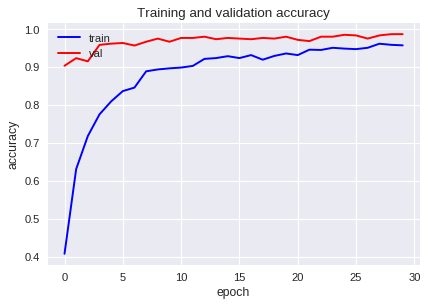

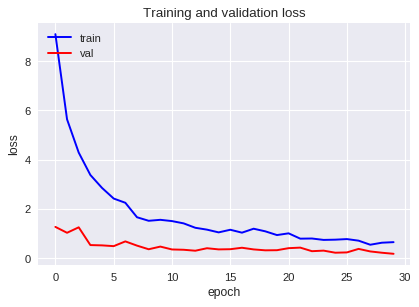

In [25]:
draw_training_history(history)

On voit qu'au delà de 30 epochs, l'accuracy se stabilise.

## 3.3 Entrainement ResNet50

In [0]:
resnet_epochs = 10
resnet_drop_rate = 0.5
resnet_model_weigths_file = 'ResNet50_top_model_weights.h5'

In [27]:
history = fit_new_model(x_train_resNet50, y_train_resNet50, resnet_epochs, resnet_drop_rate, resnet_model_weigths_file)

Train on 1400 samples, validate on 600 samples
Epoch 1/10
1400/1400 [==============================] - 2s 2ms/step - loss: 0.5035 - acc: 0.8057 - val_loss: 0.0579 - val_acc: 0.9833

Epoch 00001: val_loss improved from inf to 0.05786, saving model to ResNet50_top_model_weights.h5
Epoch 2/10
1400/1400 [==============================] - 0s 266us/step - loss: 0.1280 - acc: 0.9600 - val_loss: 0.0638 - val_acc: 0.9767

Epoch 00002: val_loss did not improve from 0.05786
Epoch 3/10
1400/1400 [==============================] - 0s 262us/step - loss: 0.0608 - acc: 0.9829 - val_loss: 0.0308 - val_acc: 0.9900

Epoch 00003: val_loss improved from 0.05786 to 0.03082, saving model to ResNet50_top_model_weights.h5
Epoch 4/10
1400/1400 [==============================] - 0s 251us/step - loss: 0.0608 - acc: 0.9836 - val_loss: 0.0260 - val_acc: 0.9933

Epoch 00004: val_loss improved from 0.03082 to 0.02598, saving model to ResNet50_top_model_weights.h5
Epoch 5/10
1400/1400 [==============================] 

=> On obtient une accuracy pour les données de validation de 99,66%

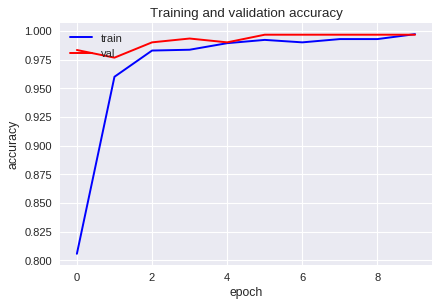

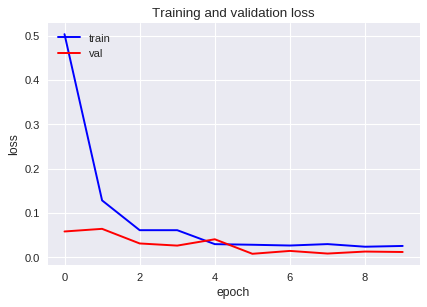

In [28]:
draw_training_history(history)

On voit qu'au delà de 4 epochs, l'accuracy se stabilise.

## 3.4 Entrainement InceptionV3

In [0]:
inception_epochs = 30
inception_drop_rate = 0.5
inception_model_weigths_file = 'InceptionV3_top_model_weights.h5'

In [30]:
history = fit_new_model(x_train_inceptionV3, y_train_inceptionV3, inception_epochs, inception_drop_rate, inception_model_weigths_file)

Train on 1400 samples, validate on 600 samples
Epoch 1/30
1400/1400 [==============================] - 3s 2ms/step - loss: 2.7757 - acc: 0.7457 - val_loss: 0.2115 - val_acc: 0.9717

Epoch 00001: val_loss improved from inf to 0.21153, saving model to InceptionV3_top_model_weights.h5
Epoch 2/30
1400/1400 [==============================] - 1s 799us/step - loss: 0.6405 - acc: 0.9371 - val_loss: 0.2141 - val_acc: 0.9817

Epoch 00002: val_loss did not improve from 0.21153
Epoch 3/30
1400/1400 [==============================] - 1s 794us/step - loss: 0.5144 - acc: 0.9507 - val_loss: 0.1933 - val_acc: 0.9783

Epoch 00003: val_loss improved from 0.21153 to 0.19334, saving model to InceptionV3_top_model_weights.h5
Epoch 4/30
1400/1400 [==============================] - 1s 812us/step - loss: 0.4897 - acc: 0.9471 - val_loss: 0.1115 - val_acc: 0.9900

Epoch 00004: val_loss improved from 0.19334 to 0.11155, saving model to InceptionV3_top_model_weights.h5
Epoch 5/30
1400/1400 [=======================

=> On obtient une accuracy pour les données de validation de 98,5%

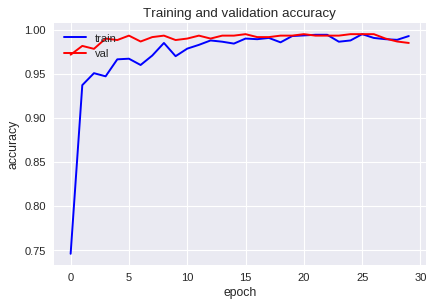

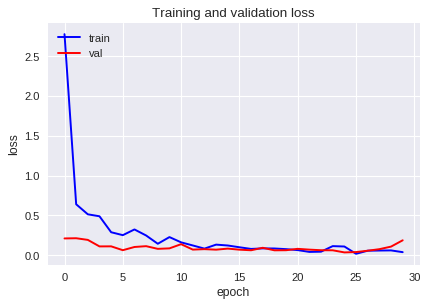

In [31]:
draw_training_history(history)

On voit qu'au delà de 15 epochs, l'accuracy se stabilise.

# 4. Evaluation

- Evaluons et comparons nos algorithmes à partir de nos données de tests.

## 4.1 VGG16

In [32]:
vgg_model = create_model_(x_train_vgg16, vgg_drop_rate)
vgg_model.load_weights(vgg_model_weigths_file, by_name=False)

# evaluate test accuracy
score = vgg_model.evaluate(x_test_vgg16, y_test_vgg16, batch_size, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 96.3277%


## 4.2 ResNet50

In [33]:
resnet_model = create_model_(x_train_resNet50, resnet_drop_rate)
resnet_model.load_weights(resnet_model_weigths_file, by_name=False)

# evaluate test accuracy
score = resnet_model.evaluate(x_test_resNet50, y_test_resNet50, batch_size, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 98.8701%


## 4.3 InceptionV3

In [34]:
inception_model = create_model_(x_train_inceptionV3, inception_drop_rate)
inception_model.load_weights(inception_model_weigths_file, by_name=False)

# evaluate test accuracy
score = inception_model.evaluate(x_test_inceptionV3, y_test_inceptionV3, batch_size, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.1525%


# 4.4 Analyse

Si on compare les 3 modèles, c'est l'**InceptionV3** qui donne le meilleur résultat au niveau des données de test avec **99,15%**

# 5. Hyper-Paramètres Tuning

Dans cette partie nous allons essayer de "tuner" notre algorithme.

## 5.1 Préparation des données

In [0]:
x_train, y_train = x_train_inceptionV3, y_train_inceptionV3
x_test, y_test = x_test_inceptionV3, y_test_inceptionV3

## 5.2 Last Layer model

In [0]:
def create_model(dropout_rate=0.5, optimizer='adadelta') :
    model = Sequential()  
    model.add(Flatten(input_shape=x_train.shape[1:])) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

## 5.3 Tuning hyper-paramètres

- Nous allons utiliser la recherche sur grilles pour trouver les meilleurs valeurs d'hyper-paramètres.
- Les paramètres que nous optimisons : 
   - dropout_rate pour la dernière couche
   - le type d'optimiser

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size = batch_size, verbose=0)

In [0]:
dropout_rate = [0.3,  0.5, 0.8]
optimizer = ['rmsprop','adadelta', 'Adam', 'Adamax']
param_grid = dict(optimizer=optimizer, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator = model,  param_grid=param_grid , cv = 3)

In [41]:
start_time = time()
grid_result = grid.fit(x_train, y_train)
print("Evaluation elapsed time : %0.2fs."%(time() - start_time))
# summarize results
print("Best: using %s" % (grid_result.best_params_))
top_model = grid.best_estimator_

Evaluation elapsed time : 735.48s.
Best: using {'dropout_rate': 0.5, 'optimizer': 'Adam'}


## 5.4 Evaluation avec les données de test

In [42]:
y_pred = grid.predict(x_test)
print("=> Classification accuracy: {:.2f} % \n".format(100*metrics.accuracy_score(y_test, y_pred)))
report = classification_report(y_test, y_pred)
print(report)

=> Classification accuracy: 99.15 % 

             precision    recall  f1-score   support

          0       0.98      1.00      0.99        52
          1       0.99      0.99      0.99       152
          2       0.98      0.98      0.98        58
          3       1.00      0.99      0.99        92

avg / total       0.99      0.99      0.99       354



=> La performance reste toujours à 99,15%.

## 5.5 Sauvegarde du modèle

In [0]:
# saving model
json_model = top_model.model.to_json()
open('top_model_architecture.json', 'w').write(json_model)
# saving weights
top_model.model.save_weights('top_model_weights.h5', overwrite=True)

In [0]:
files.download('top_model_architecture.json')

In [0]:
files.download('top_model_weights.h5')